<a href="https://colab.research.google.com/github/WittmannF/course-v4/blob/master/nbs/06_multicat_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Let's first download a utility file for setting up Google Colab
!wget https://raw.githubusercontent.com/WittmannF/course-v4/master/utils/colab_utils.py

--2020-04-22 02:32:15--  https://raw.githubusercontent.com/WittmannF/course-v4/master/utils/colab_utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1214 (1.2K) [text/plain]
Saving to: ‘colab_utils.py’

colab_utils.py      100%[===================>]   1.19K  --.-KB/s    in 0s      

2020-04-22 02:32:15 (67.4 MB/s) - ‘colab_utils.py’ saved [1214/1214]



In [0]:
from colab_utils import setup_fastai_colab
setup_fastai_colab()

    NOTE: For debugging and visualizing stdout, please run:
    from colab_utils import *
    !{REQUIREMENTS_PIP}
    !{GIT_CLONE_REPOSITORY}
    %cd {FASTAI_NB_PATH}

Installing requirements...
Done!
Cloning FastAI Repository...
Done!
Opening folder course-v4/nbs/ with nbs and utils files...
Done!


In [0]:
#hide
from utils import *

# Other computer vision problems

## Multi-label classification

### The data

In [0]:
from fastai2.vision.all import *
path = untar_data(URLs.PASCAL_2007)

In [0]:
df = pd.read_csv(path/'train.csv')
df.head()

,fname,labels,is_valid
0,000005.jpg,chair,True
1,000007.jpg,car,True
2,000009.jpg,horse person,True
3,000012.jpg,car,False
4,000016.jpg,bicycle,True


### Sidebar: Pandas and DataFrames

In [0]:
df.iloc[:,0]
df.iloc[0,:]
# Trailing ‘:’s are always optional (in numpy, PyTorch, pandas, etc),
#   so this is equivalent:
df.iloc[0]

fname       000005.jpg
labels           chair
is_valid          True
Name: 0, dtype: object

In [0]:
df['fname']

0       000005.jpg
1       000007.jpg
2       000009.jpg
3       000012.jpg
4       000016.jpg
           ...    
5006    009954.jpg
5007    009955.jpg
5008    009958.jpg
5009    009959.jpg
5010    009961.jpg
Name: fname, Length: 5011, dtype: object

### End sidebar

### Constructing a data block

In [0]:
dblock = DataBlock()

In [0]:
dsets = dblock.datasets(df)

In [0]:
dsets.train[0]

(fname       008663.jpg
 labels      car person
 is_valid         False
 Name: 4346, dtype: object, fname       008663.jpg
 labels      car person
 is_valid         False
 Name: 4346, dtype: object)

In [0]:
dblock = DataBlock(get_x = lambda r: r['fname'], get_y = lambda r: r['labels'])
dsets = dblock.datasets(df)
dsets.train[0]

('005620.jpg', 'aeroplane')

In [0]:
def get_x(r): return r['fname']
def get_y(r): return r['labels']
dblock = DataBlock(get_x = get_x, get_y = get_y)
dsets = dblock.datasets(df)
dsets.train[0]

('002549.jpg', 'tvmonitor')

In [0]:
#hide
Path.BASE_PATH = path

In [0]:
def get_x(r): return path/'train'/r['fname']
def get_y(r): return r['labels'].split(' ')
dblock = DataBlock(get_x = get_x, get_y = get_y)
dsets = dblock.datasets(df)
dsets.train[0]

(Path('train/002844.jpg'), ['train'])

In [0]:
dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   get_x = get_x, get_y = get_y)
dsets = dblock.datasets(df)
dsets.train[0]

(PILImage mode=RGB size=500x375,
 TensorMultiCategory([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]))

In [0]:
idxs = torch.where(dsets.train[0][1]==1.)[0]
dsets.train.vocab[idxs]

(#1) ['dog']

In [0]:
def splitter(df):
    train = df.index[~df['is_valid']].tolist()
    valid = df.index[df['is_valid']].tolist()
    return train,valid

dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   splitter=splitter,
                   get_x=get_x, 
                   get_y=get_y)

dsets = dblock.datasets(df)
dsets.train[0]

(PILImage mode=RGB size=500x333,
 TensorMultiCategory([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))

In [0]:
dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   splitter=splitter,
                   get_x=get_x, 
                   get_y=get_y,
                   item_tfms = RandomResizedCrop(128, min_scale=0.35))
dls = dblock.dataloaders(df)

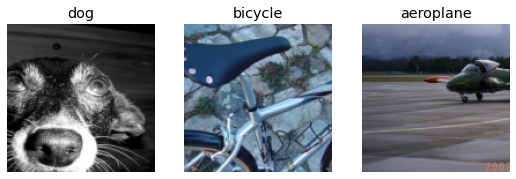

In [0]:
dls.show_batch(nrows=1, ncols=3)

### Binary cross entropy

In [0]:
learn = cnn_learner(dls, resnet18)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth


In [0]:
x,y = dls.train.one_batch()
activs = learn.model(x)
activs.shape

torch.Size([64, 20])

In [0]:
activs[0]

tensor([ 1.0136,  0.0055, -0.6758, -1.8238,  0.8897,  1.2907,  2.0263, -2.5185, -1.2441, -0.5876, -1.0882,  1.4953, -3.3978,  0.9362, -0.8014,  0.9419, -0.2365,  2.5062, -2.4360,  3.4255],
       device='cuda:0', grad_fn=<SelectBackward>)

In [0]:
def binary_cross_entropy(inputs, targets):
    inputs = inputs.sigmoid()
    return torch.where(targets==1, 1-inputs, inputs).log().mean()

In [0]:
loss_func = nn.BCEWithLogitsLoss()
loss = loss_func(activs, y)
loss

tensor(1.0750, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)

In [0]:
def say_hello(name, say_what="Hello"): 
    return f"{say_what} {name}."
say_hello('Jeremy'),say_hello('Jeremy', 'Ahoy!')

('Hello Jeremy.', 'Ahoy! Jeremy.')

In [0]:
f = partial(say_hello, say_what="Bonjour")
f("Jeremy"),f("Sylvain")

('Bonjour Jeremy.', 'Bonjour Sylvain.')

In [0]:
learn = cnn_learner(dls, resnet50, metrics=partial(accuracy_multi, thresh=0.2))
learn.fine_tune(3, base_lr=3e-3, freeze_epochs=4)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.945478,0.704644,0.235697,00:31
1,0.824519,0.561785,0.281175,00:31
2,0.602964,0.204971,0.812450,00:32
3,0.360746,0.123730,0.944263,00:31


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.131741,0.116445,0.944163,00:32
1,0.114361,0.108719,0.952092,00:32
2,0.096152,0.102991,0.951773,00:32


In [0]:
learn.metrics = partial(accuracy_multi, thresh=0.1)
learn.validate()

(#2) [0.10299073159694672,0.9293227195739746]

In [0]:
learn.metrics = partial(accuracy_multi, thresh=0.99)
learn.validate()

(#2) [0.10299073159694672,0.9435458183288574]

In [0]:
preds,targs = learn.get_preds()

In [0]:
accuracy_multi(preds, targs, thresh=0.9, sigmoid=False)

tensor(0.9569)

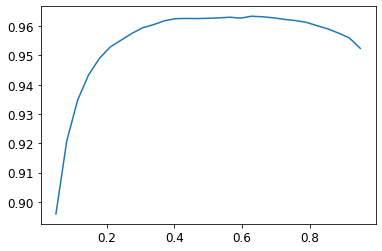

In [0]:
xs = torch.linspace(0.05,0.95,29)
accs = [accuracy_multi(preds, targs, thresh=i, sigmoid=False) for i in xs]
plt.plot(xs,accs);

## Regression

### Assemble the data

In [0]:
path = untar_data(URLs.BIWI_HEAD_POSE)

In [0]:
#hide
Path.BASE_PATH = path

In [0]:
path.ls()

(#50) [Path('03'),Path('16'),Path('10'),Path('09.obj'),Path('11'),Path('17'),Path('04.obj'),Path('11.obj'),Path('23.obj'),Path('08.obj')...]

In [0]:
(path/'01').ls()

(#1000) [Path('01/frame_00341_pose.txt'),Path('01/frame_00172_rgb.jpg'),Path('01/frame_00276_rgb.jpg'),Path('01/frame_00483_pose.txt'),Path('01/frame_00158_rgb.jpg'),Path('01/frame_00385_pose.txt'),Path('01/frame_00448_pose.txt'),Path('01/frame_00275_pose.txt'),Path('01/frame_00252_rgb.jpg'),Path('01/frame_00310_pose.txt')...]

In [0]:
img_files = get_image_files(path)
def img2pose(x): return Path(f'{str(x)[:-7]}pose.txt')
img2pose(img_files[0])

Path('03/frame_00172_pose.txt')

In [0]:
im = PILImage.create(img_files[0])
im.shape

(480, 640)

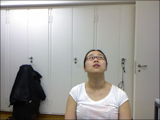

In [0]:
im.to_thumb(160)

In [0]:
cal = np.genfromtxt(path/'01'/'rgb.cal', skip_footer=6)
def get_ctr(f):
    ctr = np.genfromtxt(img2pose(f), skip_header=3)
    c1 = ctr[0] * cal[0][0]/ctr[2] + cal[0][2]
    c2 = ctr[1] * cal[1][1]/ctr[2] + cal[1][2]
    return tensor([c1,c2])

In [0]:
get_ctr(img_files[0])

tensor([390.4480, 243.5416])

In [0]:
biwi = DataBlock(
    blocks=(ImageBlock, PointBlock),
    get_items=get_image_files,
    get_y=get_ctr,
    splitter=FuncSplitter(lambda o: o.parent.name=='13'),
    batch_tfms=[*aug_transforms(size=(240,320)), 
                Normalize.from_stats(*imagenet_stats)]
)

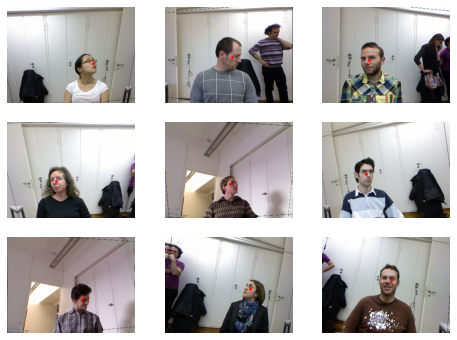

In [0]:
dls = biwi.dataloaders(path)
dls.show_batch(max_n=9, figsize=(8,6))

In [0]:
xb,yb = dls.one_batch()
xb.shape,yb.shape

(torch.Size([64, 3, 240, 320]), torch.Size([64, 1, 2]))

In [0]:
yb[0]

tensor([[ 0.0331, -0.0130]], device='cuda:0')

### Training a model

In [0]:
learn = cnn_learner(dls, resnet18, y_range=(-1,1))

In [0]:
def sigmoid_range(x, lo, hi): return torch.sigmoid(x) * (hi-lo) + lo

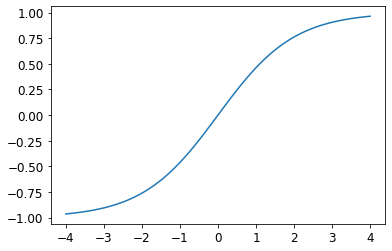

In [0]:
plot_function(partial(sigmoid_range,lo=-1,hi=1), min=-4, max=4)

In [0]:
dls.loss_func

FlattenedLoss of MSELoss()

SuggestedLRs(lr_min=0.010000000149011612, lr_steep=0.0002290867705596611)

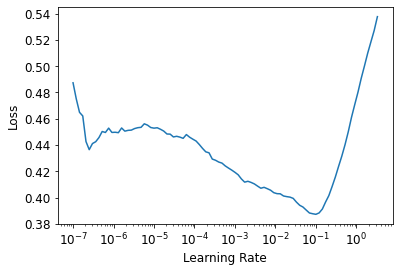

In [0]:
learn.lr_find()

In [0]:
lr = 2e-2
learn.fit_one_cycle(5, lr)

epoch,train_loss,valid_loss,time
0,0.048836,0.038270,02:12
1,0.006707,0.001371,02:12
2,0.003148,0.001629,02:12
3,0.002198,0.000234,02:12
4,0.001525,0.000249,02:13


In [0]:
math.sqrt(0.0001)

0.01

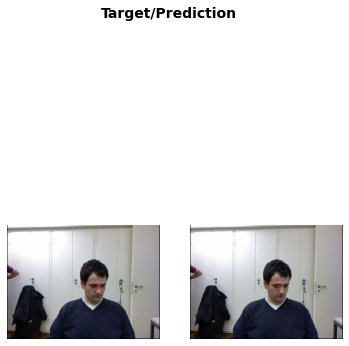

In [0]:
learn.show_results(ds_idx=1, max_n=3, figsize=(6,8))

## Conclusion

## Questionnaire

1. how could multi-label classification improve the usability of the bear classifier?
1. How do we encode the dependent variable in a multi-label classification problem?
1. How do you access the rows and columns of a DataFrame as if it was a matrix?
1. How do you get a column by name from a DataFrame?
1. What is the difference between a dataset and DataLoader?
1. What does a Datasets object normally contain?
1. What does a DataLoaders object normally contain?
1. What does lambda do in Python?
1. What are the methods to customise how the independent and dependent variables are created with the data block API?
1. Why is softmax not an appropriate output activation function when using a one hot encoded target?
1. Why is nll_loss not an appropriate loss function when using a one hot encoded target?
1. What is the difference between `nn.BCELoss` and `nn.BCEWithLogitsLoss`?
1. Why can't we use regular accuracy in a multi-label problem?
1. When is it okay to tune an hyper-parameter on the validation set?
1. How is `y_range` implemented in fastai? (See if you can implement it yourself and test it without peaking!)
1. What is a regression problem? What loss function should you use for such a problem?
1. What do you need to do to make sure the fastai library applies the same data augmentation to your inputs images and your target point coordinates?

### Further research

1. Read a tutorial about pandas DataFrames and experiment with a few methods that look interesting to you. Have a look at the book website for recommended tutorials.
1. Retrain the bear classifier using multi-label classification. See if you can make it work effectively with images that don't contain any bears, including showing that information in the web application. Try an image with two different kinds of bears. Check whether the accuracy on the single label dataset is impacted using multi-label classification.